<a href="https://colab.research.google.com/github/Hamxea/Multi-label-Classification/blob/master/Multi_Label_Classification_Using_Wikipedia_Toxic_Comments_Dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Multi-Label Text Classification of Text Documnet or News




 ### DATASET

Toxic Comment Classification dataset. a multi-label text classfication data consisting of many wikipedia comments which have been labeled by humans according to their relative toxicity comments labels such as "toxic", "severe_toxic", "obscene", "threat", "insult", and  "identity_hate". The dataset has approximately ~160k observation in total, ~125k with zero labels (toxicity) of any type, and approximately ~35k classified in one or more toxicity categories.



#### DATA CHARACTERISTICS (TRAIN DATASET)
* Number of data points	159571
* Number data points of type toxic	15294
* Number data points of type severe_tocic	1595
* Number data points of type obscene	8449
* Number data points of type threat	478
* Number data points of type insult	7877
* Number data points of type identity_hate	1405
* Observations in one or more class	35098
* Unclassified observation	124473


### Import necessary libraries for the experiment

In [61]:
# importing libraries
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing import text, sequence
from keras import initializers, regularizers, constraints, optimizers, layers
from keras.models import Model, Input, Sequential
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, SpatialDropout1D, Activation
from keras.layers import Conv1D, Bidirectional, GlobalMaxPool1D, MaxPooling1D, BatchNormalization
from keras.optimizers import Adam
from keras.utils.vis_utils import plot_model

# For custom metrics
import keras.backend as K
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping 


import pandas as pd
import numpy as np
 
import matplotlib.pyplot as plt

plt.style.use('seaborn')

import seaborn as sns
from IPython.display import Image

from tqdm import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
import os, re, csv, math, codecs
from nltk.tokenize import word_tokenize
import string
import gensim
import os

sns.set_style("whitegrid")
np.random.seed(0)

# Install dependencies
!apt install graphviz
!pip install pydot pydot-ng
!echo "Double check with Python 3"
!python -c "import pydot"

Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-410
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 11 not upgraded.
Double check with Python 3


### Loading the necessary data files and data Preparation

In [0]:
#from google.colab import files
#uploaded = files.upload()

In [63]:
#Train data
train = pd.read_csv('train.csv')
train.head(10)

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0
5,00025465d4725e87,"""\n\nCongratulations from me as well, use the ...",0,0,0,0,0,0
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
7,00031b1e95af7921,Your vandalism to the Matt Shirvington article...,0,0,0,0,0,0
8,00037261f536c51d,Sorry if the word 'nonsense' was offensive to ...,0,0,0,0,0,0
9,00040093b2687caa,alignment on this subject and which are contra...,0,0,0,0,0,0


In [64]:
#Test data
df_test = pd.read_csv('test.csv')
df_test.head(10)

,id,comment_text
0,00001cee341fdb12,Yo bitch Ja Rule is more succesful then you'll...
1,0000247867823ef7,== From RfC == \n\n The title is fine as it is...
2,00013b17ad220c46,""" \n\n == Sources == \n\n * Zawe Ashton on Lap..."
3,00017563c3f7919a,":If you have a look back at the source, the in..."
4,00017695ad8997eb,I don't anonymously edit articles at all.
5,0001ea8717f6de06,Thank you for understanding. I think very high...
6,00024115d4cbde0f,Please do not add nonsense to Wikipedia. Such ...
7,000247e83dcc1211,:Dear god this site is horrible.
8,00025358d4737918,""" \n Only a fool can believe in such numbers. ..."
9,00026d1092fe71cc,== Double Redirects == \n\n When fixing double...


In [65]:
df_test_labels = pd.read_csv('test_labels.csv')

df_test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,00001cee341fdb12,-1,-1,-1,-1,-1,-1
1,0000247867823ef7,-1,-1,-1,-1,-1,-1
2,00013b17ad220c46,-1,-1,-1,-1,-1,-1
3,00017563c3f7919a,-1,-1,-1,-1,-1,-1
4,00017695ad8997eb,-1,-1,-1,-1,-1,-1
5,0001ea8717f6de06,0,0,0,0,0,0
6,00024115d4cbde0f,-1,-1,-1,-1,-1,-1
7,000247e83dcc1211,0,0,0,0,0,0
8,00025358d4737918,-1,-1,-1,-1,-1,-1
9,00026d1092fe71cc,-1,-1,-1,-1,-1,-1


In [66]:
test_labels = df_test_labels[(df_test_labels[['toxic','severe_toxic', 'obscene', 'threat', 
                                        'insult', 'identity_hate']] != -1).all(axis=1)]
test_labels.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate
5,0001ea8717f6de06,0,0,0,0,0,0
7,000247e83dcc1211,0,0,0,0,0,0
11,0002f87b16116a7f,0,0,0,0,0,0
13,0003e1cccfd5a40a,0,0,0,0,0,0
14,00059ace3e3e9a53,0,0,0,0,0,0
16,000663aff0fffc80,0,0,0,0,0,0
17,000689dd34e20979,0,0,0,0,0,0
19,000844b52dee5f3f,0,0,0,0,0,0
21,00091c35fa9d0465,1,0,0,0,0,0
22,000968ce11f5ee34,0,0,0,0,0,0


### Merge the df_test and test_labels into 1 dataframe (test)

In [67]:
#Merge the df_test and test_labels into 1 dataframe (test)
test = pd.merge(test_labels, df_test, on='id', how='inner')
test.head(10)

,id,toxic,severe_toxic,obscene,threat,insult,identity_hate,comment_text
0,0001ea8717f6de06,0,0,0,0,0,0,Thank you for understanding. I think very high...
1,000247e83dcc1211,0,0,0,0,0,0,:Dear god this site is horrible.
2,0002f87b16116a7f,0,0,0,0,0,0,"""::: Somebody will invariably try to add Relig..."
3,0003e1cccfd5a40a,0,0,0,0,0,0,""" \n\n It says it right there that it IS a typ..."
4,00059ace3e3e9a53,0,0,0,0,0,0,""" \n\n == Before adding a new product to the l..."
5,000663aff0fffc80,0,0,0,0,0,0,this other one from 1897
6,000689dd34e20979,0,0,0,0,0,0,== Reason for banning throwing == \n\n This ar...
7,000844b52dee5f3f,0,0,0,0,0,0,|blocked]] from editing Wikipedia. |
8,00091c35fa9d0465,1,0,0,0,0,0,"== Arabs are committing genocide in Iraq, but ..."
9,000968ce11f5ee34,0,0,0,0,0,0,Please stop. If you continue to vandalize Wiki...


### No of records in the train and test data

In [68]:
print("Train data shape", train.shape)
print("Test data shape", test.shape)

Train data shape (159571, 8)
Test data shape (63930, 8)


In [69]:
# check that there are no missing values in either training set
print('The dataset has', train.isna().sum().sum(), 'missing values in train data.')
print('The dataset has', test.isna().sum().sum(), 'missing values in test data.')

# check if there are any duplicates
print('The dataset has', train.duplicated().sum(), 'duplicates in train data.')
print('The dataset has', test.duplicated().sum(), 'duplicates in test data.')

The dataset has 0 missing values in train data.
The dataset has 0 missing values in test data.
The dataset has 0 duplicates in train data.
The dataset has 0 duplicates in test data.


### CORRELATION BETWEEN DATA LABELS

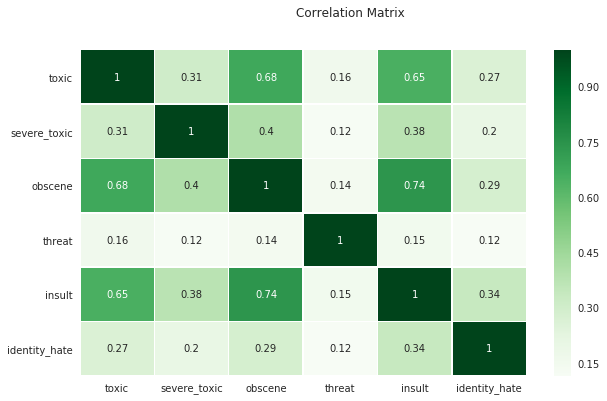

In [70]:
fig, ax = plt.subplots(figsize=(10, 6))
fig.suptitle('Correlation Matrix')
sns.heatmap(train.corr(), annot=True, cmap="Greens", linewidths=.5, ax=ax);

The correlation figure below shows that Toxic" comments are clearly correlated with both "obscene" and "insult" comments. Interestingly, "toxic" and "severe_toxic" are only weakly correlated. While we can also observe that, "Obscene" comments and "insult" comments are also highly correlated, which makes perfect sense.

### DATA PREPROCESSING
Deep Neural Networks input layers make use of input variables to feed the network for training the model. But in this task (experiment), we're dealing with words text. How do we represent these words in order to feed our model?

In our experiment, we used densed representation of those text (comments) and their semanticity together. The advantage of using this approach is the best way for fitting neural networks onto a text data (as in our case), as well as less memory usage compared to other sparse representation approaches.


#### Word Embedding
Two ways to feed embeddings to neural networks:
   * Using your own word embeddings by training
   * Using pre-trained embedding (e.g Word2vec, lad2vec, Glove etc)
   


In [0]:
#Convert text to vectors using keras preprocessing library tools

X_train = train["comment_text"].values
X_test  = test["comment_text"].values

y_train = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
y_test  = test[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values






For the first embedding, we used keras preprocessing (Text Preprocessing) libraries. This class allows to vectorize a text corpus, by turning each text into either a sequence of integers (each integer being the index of a token in a dictionary) or into a vector where the coefficient for each token could be binary, based on word count, based on tf-idf

In [72]:
#toxic comments Tokenization
tokenizer = tokenizer = Tokenizer(num_words)
tokenizer.fit_on_texts(list(X_train))

#Convert tokenized toxic commnent to sequnces
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

# padding the sequences
X_train = sequence.pad_sequences(X_train, max_len)
X_test  = sequence.pad_sequences(X_test,  max_len)

print('X_train shape:', X_train.shape)
print('X_test shape: ', X_test.shape)

X_train shape: (159571, 200)
X_test shape:  (63930, 200)


In [0]:
num_words = 20000 #Max. workds to use per toxic comment
max_features = 200000 #Max. number of unique words in embeddinbg vector
max_len = 200 #Max. number of words per toxic comment to be use
embedding_dims = 128 #embedding vector output dimension 
num_epochs = 25 # (before 5)number of epochs (number of times that the model is exposed to the training dataset)
val_split = 0.1
batch_size2 = 256 #(before 32)The **batch size** is the number of training examples in one forward/backward pass. In general, larger batch sizes result in faster progress in training, but don't always converge as quickly. Smaller batch sizes train slower, but can converge faster. And the higher the batch size, the more memory space you’ll need.

### Train, Validation, Test Splits
#### Train Data: 
The sample data used to fit the model.
#### Validation Data: 
The sample of data used to provide an unbiased evaluation of a model fit on the training dataset while tuning model hyperparameters.

#### Test Data:
The sample of data used to provide an unbiased evaluation of a final model fit on the training dataset

The test set is generally what is used to evaluate competing models (For example on many Kaggle competitions, the validation set is released initially along with the training set and the actual test set is only released when the competition is about to close, and it is the result of the the model on the Test set that decides the winner).


#### Our Experiment Splits Ratio
Split ratio on most of the experimental datasets depends mainly on two (2) things: The number of samples in the data, and the actual model you are training.

It's always good to splits in the raio of (60%:20%:20%) in terms of (Train:Validation:Test) when you have 1 dataset. But thanks to kaggle competition spits of Train dataset and Test dataset. Now, we need to compute only the validation accuracy.


In our experiment, we keep aside the Test set dataset, and used keras "validation_split" function in order to choose 80% of the Train dataset to be the actual Train set and the remaining (20%) to be the Validation set. The model is then iteratively trained and validated on these different sets.

The Train dataset consists of (159571 samples), so when to split it into train and validaton. we have train split (0.8 of train dataset) =  127657  samples, while the validation split(0.2 of Train dataset) = 31914 samples. 

Lastly, the test dataset consists of 63930 samples, therefore, we use all the samples as our test split.



## METHODS (NN, CNN, RNN, LSTM)

#### We used early callback functionality that allows you to specify the performance measure to monitor, the trigger, and once triggered. It will stop the training process.

In [0]:
early = EarlyStopping(monitor="val_loss", mode="min")

### 1) Neural Network (NN)

In [0]:
nn_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dropout(0.3),
    Dense(6, activation = 'sigmoid')
])

### Compile the NN model

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

nn_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

### Visualize the Orchestrated NN Architecture

In [77]:
nn_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 128)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 50)                6450      
_________________________________________________________________
dropout_3 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 6)                 306       
Total params: 25,606,756
Trainable params: 25,606,756
Non-trainable params: 0
_________________________________________________________________


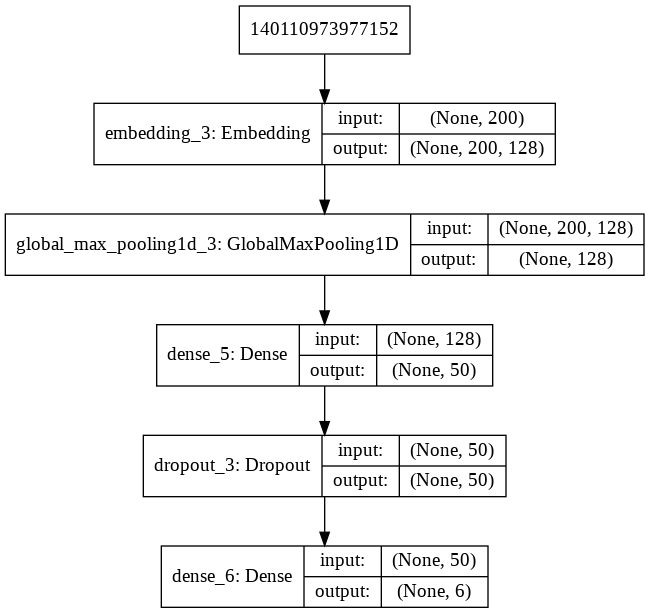

In [78]:
#plot the nn_model architecture

plot_model(nn_model, to_file='nn_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='nn_model_plot.png')

In [79]:
nn_model_fit = nn_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 13s 92us/step - loss: 0.0838 - acc: 0.9739 - mean_pred: 0.0413 - val_loss: 0.0537 - val_acc: 0.9801 - val_mean_pred: 0.0328
Epoch 2/25
143613/143613 [==============================] - 12s 86us/step - loss: 0.0480 - acc: 0.9819 - mean_pred: 0.0366 - val_loss: 0.0511 - val_acc: 0.9812 - val_mean_pred: 0.0400
Epoch 3/25
143613/143613 [==============================] - 13s 88us/step - loss: 0.0434 - acc: 0.9831 - mean_pred: 0.0366 - val_loss: 0.0508 - val_acc: 0.9814 - val_mean_pred: 0.0382
Epoch 4/25
143613/143613 [==============================] - 12s 87us/step - loss: 0.0391 - acc: 0.9842 - mean_pred: 0.0366 - val_loss: 0.0516 - val_acc: 0.9818 - val_mean_pred: 0.0354


### Evaluate the NN accuracy of our trained model

In [80]:
nn_train_score = nn_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', nn_train_score[0])
print('Train accuracy:', nn_train_score[1])

159571/159571 [==============================] - 1s 6us/step
Train loss: 0.03305892497907855
Train accuracy: 0.9863676022031288


### Evaluate the NN accuracy base on the test dataset

In [81]:
nn_test_score = nn_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', nn_test_score[0])
print('Test Accuracy:', nn_test_score[1])

63930/63930 [==============================] - 0s 6us/step
Test Loss: 0.0748103798915854
Test Accuracy: 0.9699228249859702


In [82]:
#Predicting......
print('Predicting....')
y_pred = nn_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 0s 6us/step


### Plot Training & Validation Accuracy with the Loss values of the NN Model

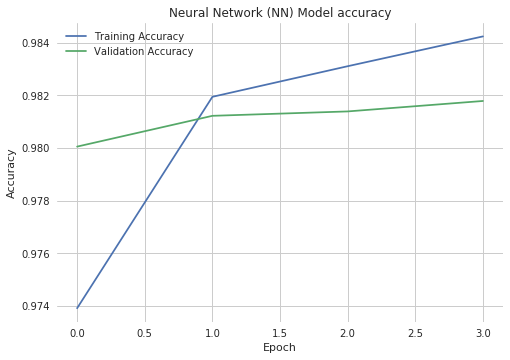

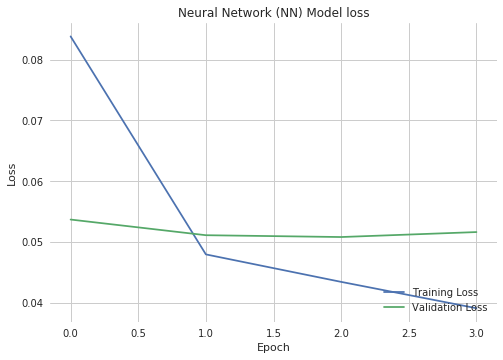

In [83]:
# Plot training & validation accuracy values
plt.plot(nn_model_fit.history['acc'])
plt.plot(nn_model_fit.history['val_acc'])
plt.title('Neural Network (NN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(nn_model_fit.history['loss'])
plt.plot(nn_model_fit.history['val_loss'])
plt.title('Neural Network (NN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 2) Convolutional Neural Network (CNN)

In [0]:
CNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

### Visualize the Orchestrated CNN MODEL Architecture

In [86]:
CNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_1 (Batch (None, 200, 100)          400       
_________________________________________________________________
dropout_4 (Dropout)          (None, 200, 100)          0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 50)                5050      
__________

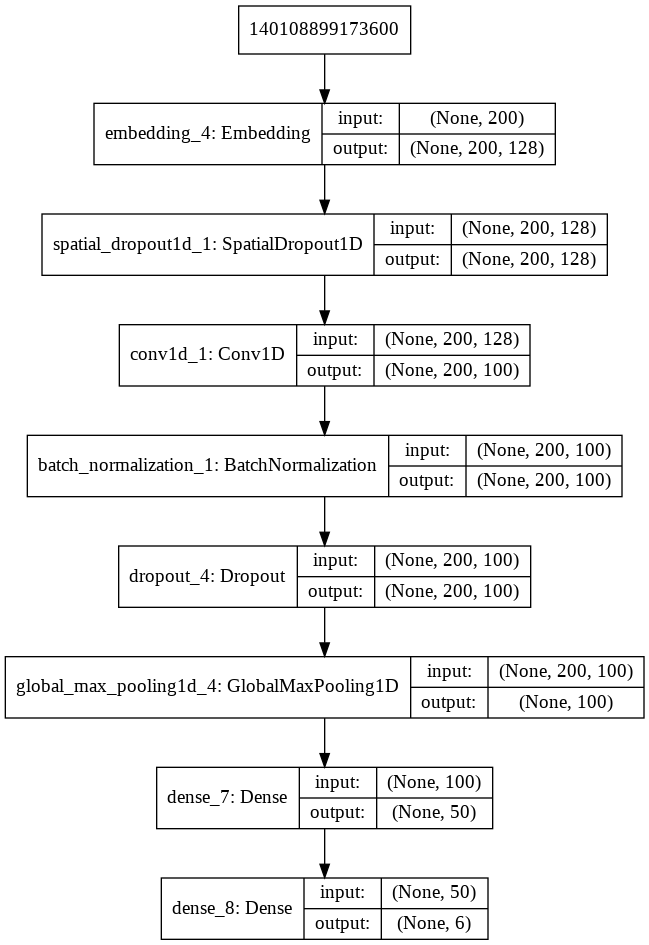

In [87]:
#plot the CNN model architecture

plot_model(CNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [88]:
CNN_model_fit = CNN_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 24s 168us/step - loss: 0.0816 - acc: 0.9755 - mean_pred: 0.0388 - val_loss: 0.0709 - val_acc: 0.9803 - val_mean_pred: 0.0596
Epoch 2/25
143613/143613 [==============================] - 20s 141us/step - loss: 0.0519 - acc: 0.9812 - mean_pred: 0.0368 - val_loss: 0.0657 - val_acc: 0.9809 - val_mean_pred: 0.0556
Epoch 3/25
143613/143613 [==============================] - 20s 141us/step - loss: 0.0464 - acc: 0.9826 - mean_pred: 0.0366 - val_loss: 0.0570 - val_acc: 0.9808 - val_mean_pred: 0.0446
Epoch 4/25
143613/143613 [==============================] - 20s 142us/step - loss: 0.0426 - acc: 0.9836 - mean_pred: 0.0366 - val_loss: 0.0529 - val_acc: 0.9814 - val_mean_pred: 0.0423
Epoch 5/25
143613/143613 [==============================] - 20s 141us/step - loss: 0.0398 - acc: 0.9844 - mean_pred: 0.0365 - val_loss: 0.0536 - val_acc: 0.9811 - val_mean_pred: 0.0443


### Evaluate the CNN Model accuracy of our trained model

In [89]:
CNN_train_score = CNN_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', CNN_train_score[0])
print('Train accuracy:', CNN_train_score[1])

159571/159571 [==============================] - 3s 21us/step
Train loss: 0.03931098836190559
Train accuracy: 0.9863331338378557


### Evaluate the CNN accuracy base our test samples

In [90]:
CNN_test_score = CNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_test_score[0])
print('Test Accuracy:', CNN_test_score[1])

63930/63930 [==============================] - 1s 21us/step
Test Loss: 0.08272853083389943
Test Accuracy: 0.9666093017431039


In [91]:
#Predicting......
print('Predicting....')
y_pred = CNN_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 1s 21us/step


### Plot Training & Validation Accuracy with the Loss values of the CNN Model

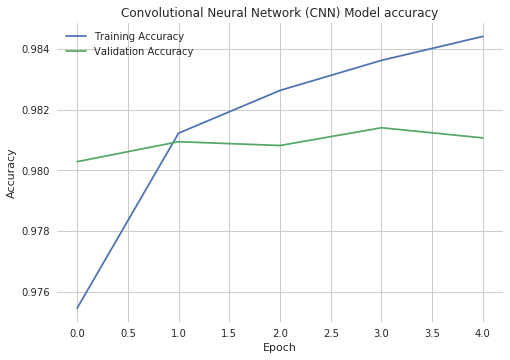

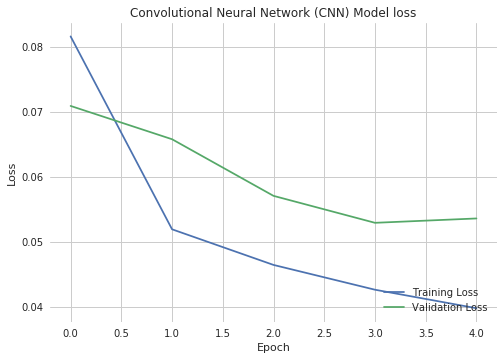

In [92]:
# Plot training & validation accuracy values
plt.plot(CNN_model_fit.history['acc'])
plt.plot(CNN_model_fit.history['val_acc'])
plt.title('Convolutional Neural Network (CNN) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_model_fit.history['loss'])
plt.plot(CNN_model_fit.history['val_loss'])
plt.title('Convolutional Neural Network (CNN) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 3) Recurrent Neural Networks (RNNs)

In [0]:
RNN_model = Sequential([
    Embedding(input_dim=max_features, input_length=max_len, output_dim=embedding_dims),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

### Visualize the Orchestrated RNN MODEL Architecture

In [95]:
RNN_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 200, 128)          25600000  
_________________________________________________________________
spatial_dropout1d_2 (Spatial (None, 200, 128)          0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 200, 50)           30800     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_5 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 50)                0         
_________________________________________________________________
dense_9 (Dense)              (None, 50)                2550      
__________

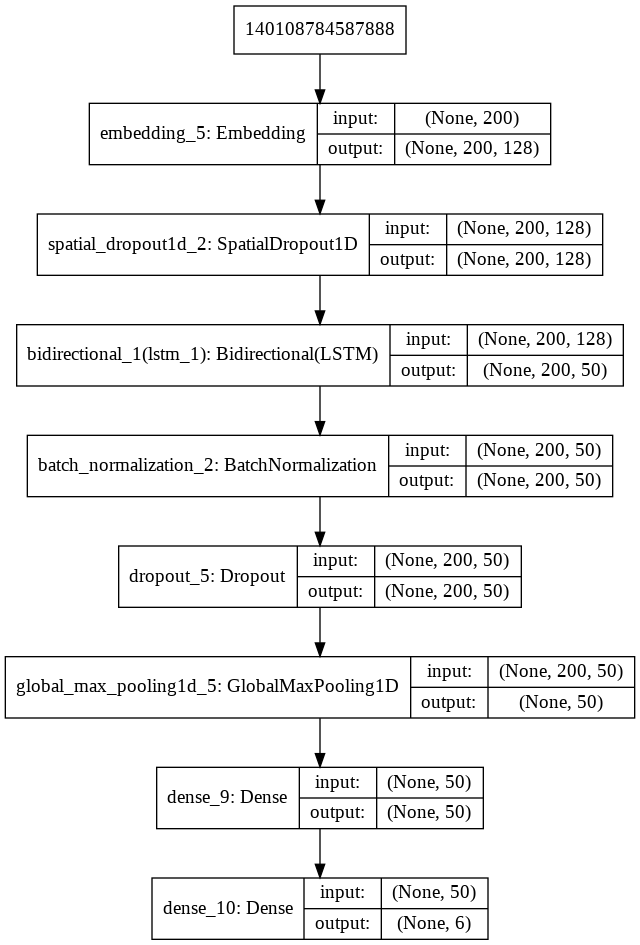

In [96]:
#plot the RNN model architecture

plot_model(RNN_model, to_file='CNN_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_model_plot.png')

In [97]:
RNN_model_fit = RNN_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 362s 3ms/step - loss: 0.0627 - acc: 0.9783 - mean_pred: 0.0375 - val_loss: 0.0580 - val_acc: 0.9818 - val_mean_pred: 0.0473
Epoch 2/25
143613/143613 [==============================] - 362s 3ms/step - loss: 0.0466 - acc: 0.9828 - mean_pred: 0.0367 - val_loss: 0.0563 - val_acc: 0.9827 - val_mean_pred: 0.0490
Epoch 3/25
143613/143613 [==============================] - 358s 2ms/step - loss: 0.0434 - acc: 0.9838 - mean_pred: 0.0367 - val_loss: 0.0703 - val_acc: 0.9810 - val_mean_pred: 0.0639


### Evaluate the RNN Model accuracy of our trained model

In [98]:
RNN_train_score = RNN_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_train_score[0])
print('Test Accuracy:', RNN_train_score[1])

159571/159571 [==============================] - 149s 935us/step
Test Loss: 0.06351435804621197
Test Accuracy: 0.9848938543519484


### Evaluate the RNN accuracy base our test samples

In [99]:
RNN_test_score = RNN_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_test_score[0])
print('Test Accuracy:', RNN_test_score[1])

63930/63930 [==============================] - 60s 943us/step
Test Loss: 0.09824483349847063
Test Accuracy: 0.9665780168024938


### Plot Training & Validation Accuracy with the Loss values of the RNN Model

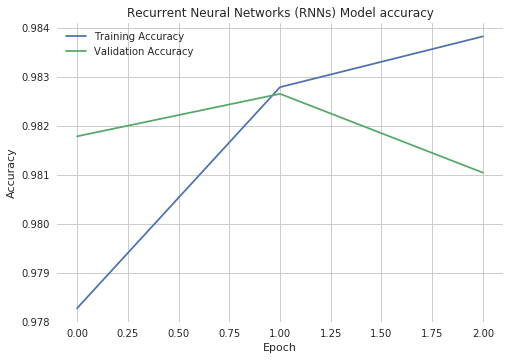

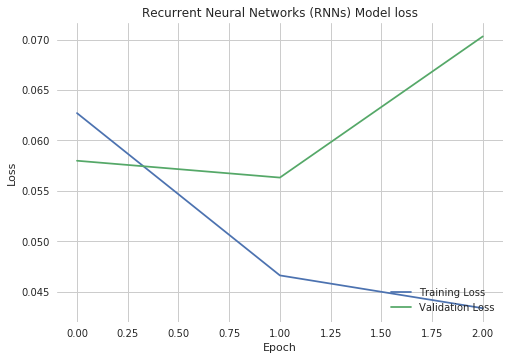

In [100]:
# Plot training & validation accuracy values
plt.plot(RNN_model_fit.history['acc'])
plt.plot(RNN_model_fit.history['val_acc'])
plt.title('Recurrent Neural Networks (RNNs) Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(RNN_model_fit.history['loss'])
plt.plot(RNN_model_fit.history['val_loss'])
plt.title('Recurrent Neural Networks (RNNs) Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### USING PRE-TRAINED EMBEDDING

## A) "Glove" as a pre-trained Embedding

#### Prepare the pre-trained embedding layer

Load glove embedding corpus

In [101]:
glove_file = open('glove.6B.100d.txt', encoding="utf8")
embeddings_index = dict()
for line in glove_file:
    val = line.split(' ')
    word = val[0]
    coefs = np.asarray(val[1:], dtype='float32')
    embeddings_index[word] = coefs
glove_file.close()

print('Loaded %s word vectors.' % len(embeddings_index))

Loaded 400000 word vectors.


#### Prepare the embedding matrix vectors in order to feed/pass the neural network

In [0]:
# create a weight matrix
embedding_matrix = np.zeros((len(tokenizer.word_index)+1, 100))

for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

### 4) Convolutional Neural Network (CNN) with Glove

In [0]:
CNN_Glove_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_Glove_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

### Visualize the Orchestrated CNN-Glove Model Architecture

In [105]:
CNN_Glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 200, 100)          21033800  
_________________________________________________________________
spatial_dropout1d_3 (Spatial (None, 200, 100)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 200, 100)          40100     
_________________________________________________________________
batch_normalization_3 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 100)               0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 50)                5050      
__________

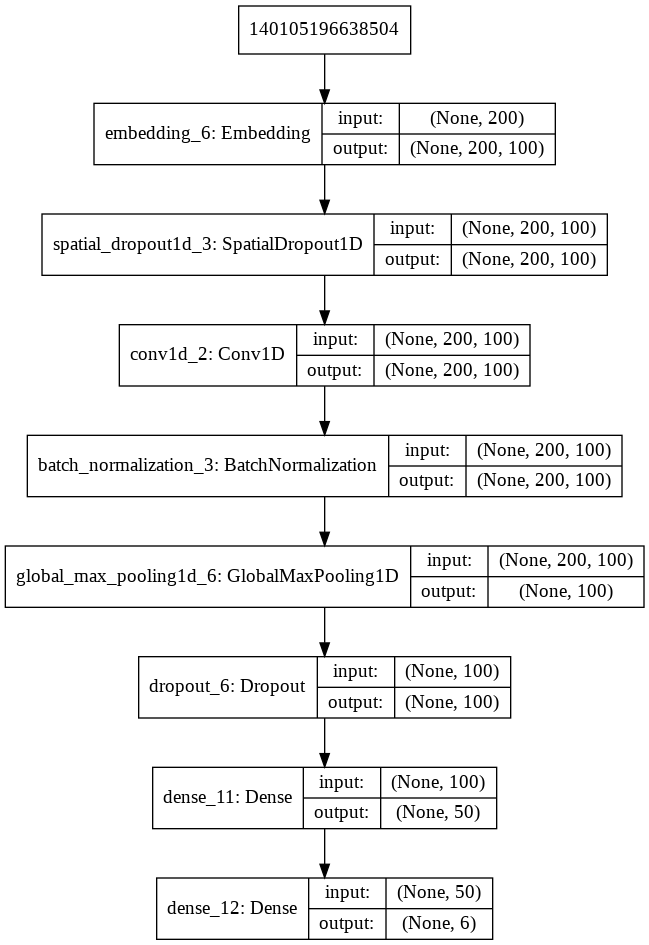

In [106]:
#plot the CNN_GLove model architecture

plot_model(CNN_Glove_model, to_file='CNN_Glove_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_Glove_model_plot.png')

In [107]:
CNN_Glove_model_fit = CNN_Glove_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 8s 56us/step - loss: 0.1313 - acc: 0.9677 - mean_pred: 0.0375 - val_loss: 0.0768 - val_acc: 0.9713 - val_mean_pred: 0.0323
Epoch 2/25
143613/143613 [==============================] - 7s 48us/step - loss: 0.0861 - acc: 0.9716 - mean_pred: 0.0370 - val_loss: 0.0716 - val_acc: 0.9744 - val_mean_pred: 0.0344
Epoch 3/25
143613/143613 [==============================] - 7s 48us/step - loss: 0.0809 - acc: 0.9728 - mean_pred: 0.0369 - val_loss: 0.0667 - val_acc: 0.9762 - val_mean_pred: 0.0291
Epoch 4/25
143613/143613 [==============================] - 7s 49us/step - loss: 0.0768 - acc: 0.9739 - mean_pred: 0.0366 - val_loss: 0.0641 - val_acc: 0.9774 - val_mean_pred: 0.0381
Epoch 5/25
143613/143613 [==============================] - 7s 50us/step - loss: 0.0745 - acc: 0.9744 - mean_pred: 0.0367 - val_loss: 0.0624 - val_acc: 0.9785 - val_mean_pred: 0.0397
Epoch 6/25
143613/143613 [========

### Evaluate the CNN+Glove Model accuracy of our trained model

In [108]:
CNN_Glove_train_score = CNN_Glove_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Glove_train_score[0])
print('Train Accuracy:', CNN_Glove_train_score[1])

159571/159571 [==============================] - 3s 18us/step
Test Loss: 0.05709397811295419
Test Accuracy: 0.9792568708434167


### Evaluate the CNN+Glove accuracy base our test samples

In [109]:
CNN_Glove_test_score = CNN_Glove_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Glove_test_score[0])
print('Test Accuracy:', CNN_Glove_test_score[1])

63930/63930 [==============================] - 1s 19us/step
Test Loss: 0.0714651698099463
Test Accuracy: 0.9729156801571183


In [110]:
#Predicting......
print('Predicting....')
y_pred = CNN_Glove_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 1s 21us/step


### Plot Training & Validation Accuracy with the Loss values of the CNN-Glove Model

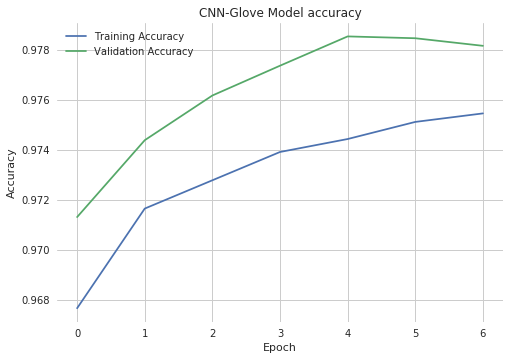

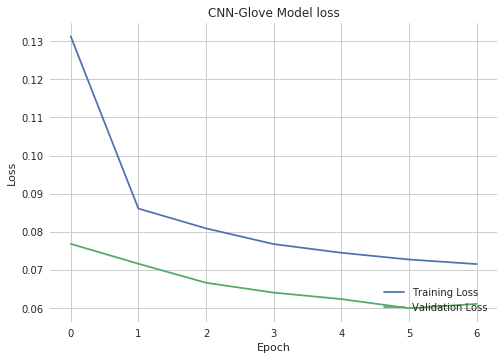

In [111]:
# Plot training & validation accuracy values
plt.plot(CNN_Glove_model_fit.history['acc'])
plt.plot(CNN_Glove_model_fit.history['val_acc'])
plt.title('CNN-Glove Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(CNN_Glove_model_fit.history['loss'])
plt.plot(CNN_Glove_model_fit.history['val_loss'])
plt.title('CNN-Glove Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 5) Recurrent Neural Network (RNN) with Glove

In [0]:
RNN_Glove_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_Glove_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

### Visualize the Orchestrated RNN-Glove MODEL Architecture

In [114]:
RNN_Glove_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 200, 100)          21033800  
_________________________________________________________________
spatial_dropout1d_4 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_2 (Bidirection (None, 200, 50)           25200     
_________________________________________________________________
batch_normalization_4 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_7 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 50)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 50)                2550      
__________

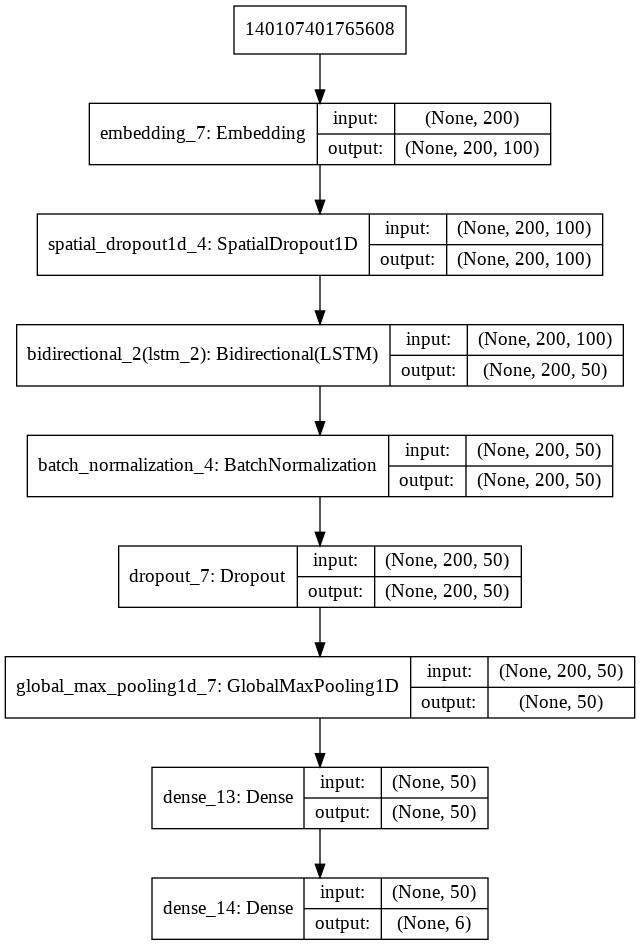

In [115]:
#plot the RNN_GLove model architecture

plot_model(RNN_Glove_model, to_file='RNN_Glove_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_Glove_model_plot.png')

In [116]:
RNN_Glove_model_fit = RNN_Glove_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 325s 2ms/step - loss: 0.0804 - acc: 0.9731 - mean_pred: 0.0376 - val_loss: 0.0968 - val_acc: 0.9788 - val_mean_pred: 0.0825
Epoch 2/25
143613/143613 [==============================] - 325s 2ms/step - loss: 0.0653 - acc: 0.9772 - mean_pred: 0.0367 - val_loss: 0.0825 - val_acc: 0.9798 - val_mean_pred: 0.0703
Epoch 3/25
143613/143613 [==============================] - 325s 2ms/step - loss: 0.0631 - acc: 0.9777 - mean_pred: 0.0367 - val_loss: 0.0719 - val_acc: 0.9800 - val_mean_pred: 0.0593
Epoch 4/25
143613/143613 [==============================] - 324s 2ms/step - loss: 0.0613 - acc: 0.9782 - mean_pred: 0.0367 - val_loss: 0.0723 - val_acc: 0.9801 - val_mean_pred: 0.0611


### Evaluate the RNN-Glove Model accuracy of our trained model

In [117]:
RNN_Glove_train_score = RNN_Glove_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', RNN_Glove_train_score[0])
print('Train accuracy:', RNN_Glove_train_score[1])

159571/159571 [==============================] - 149s 931us/step
Train loss: 0.07041054403795394
Train accuracy: 0.9808413278517844


### Evaluate the RNN-Glove accuracy base our test samples

In [118]:
RNN_Glove_test_score = RNN_Glove_model.evaluate(X_train, y_train, batch_size = batch_size2, verbose = 1)
print('Train loss:', RNN_Glove_test_score[0])
print('Train accuracy:', RNN_Glove_test_score[1])

159571/159571 [==============================] - 148s 927us/step
Train loss: 0.07041054403795394
Train accuracy: 0.9808413278517844


italicized text### Plot Training & Validation Accuracy with the Loss values of the RNN-Glove Model

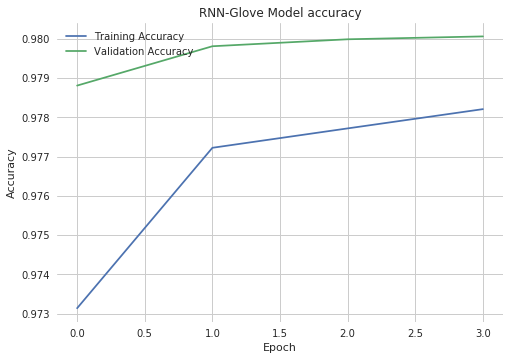

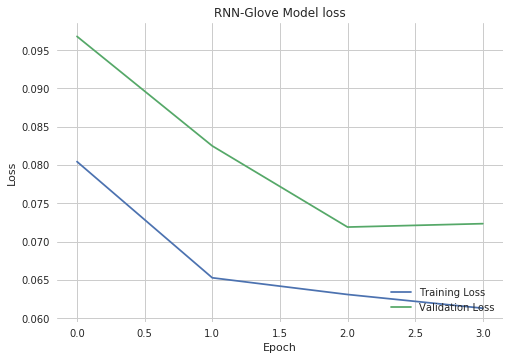

In [119]:
# Plot training & validation accuracy values
plt.plot(RNN_Glove_model_fit.history['acc'])
plt.plot(RNN_Glove_model_fit.history['val_acc'])
plt.title('RNN-Glove Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(RNN_Glove_model_fit.history['loss'])
plt.plot(RNN_Glove_model_fit.history['val_loss'])
plt.title('RNN-Glove Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## B) "Word2Vec" as a pre-Trained Embedding

Firstly, we separately learnt word embeddings and then pass to the embedding layer. This approach allows to use  pre-trained (Word2Vec) word embedding and also saves the time in training the classification model.

In this part of experiment, we used Geness implementaion of Word2Vec.

### Create the word tokens in order to prepare the Text corpus for leanring the embedding

In [127]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [128]:
toxicComments_lines = list()
lines = train['comment_text'].values.tolist()

for line in lines:
    tokens = word_tokenize(line)
    
    #convert to lower case
    tokens = [w.lower() for w in tokens]
    
    #remove punctuation from each word
    table =  str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    
    #remove remaining tpkens gthat are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    
    #filter out stop words
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    toxicComments_lines.append(words)


len(toxicComments_lines)

159571

### Train the Word2Vec

In [129]:
#train word2vec mode
embedding_dims = 128 #embedding vector output dimension 
max_len = 200 #Max. number of words per toxic comment to be use
word2VecModel = gensim.models.Word2Vec(sentences=toxicComments_lines, size= embedding_dims, window=5, workers=4, min_count=1)
#vocab size
wors = list(word2VecModel.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 19


#### Test Word2Vec Model of the toxic comment corpus. We tried some word embeddings from the model learnt from the wikipedia toxic comment tran dataset

In [130]:
word2VecModel.wv.most_similar('shit')

/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


[('worthless', 0.826896607875824),
 ('crap', 0.7721754312515259),
 ('garbage', 0.7610012292861938),
 ('filth', 0.7609071731567383),
 ('imbeciles', 0.7566377520561218),
 ('fucking', 0.7536987662315369),
 ('ass', 0.7492084503173828),
 ('retards', 0.7402042150497437),
 ('puff', 0.7371159791946411),
 ('faggot', 0.7341269850730896)]

In [131]:
#Let's see the reulst of semantically reasonable word vetors (king - man + woman)
word2VecModel.wv.most_similar_cosmul(positive=['woman', 'king'], negative=['man'])

[('prince', 1.0706363916397095),
 ('edward', 1.058720350265503),
 ('born', 1.0586720705032349),
 ('gaunt', 1.0486865043640137),
 ('mary', 1.0438095331192017),
 ('israelnncom', 1.036795735359192),
 ('princess', 1.036185622215271),
 ('salutates', 1.0317230224609375),
 ('father', 1.0294922590255737),
 ('queen', 1.0284799337387085)]

In [132]:
#Let us find the odd word woman, king, queen, movie = ?
#add word out
print(word2VecModel.wv.doesnt_match("woman king queen movie".split()))

movie


/usr/local/lib/python3.6/dist-packages/gensim/models/keyedvectors.py:895: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  vectors = vstack(self.word_vec(word, use_norm=True) for word in used_words).astype(REAL)
/usr/local/lib/python3.6/dist-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


#### Save the Word2Vec Corpus locally

In [0]:
#save model
filename = 'toxic_embedding_word2vec.txt'
word2VecModel.wv.save_word2vec_format(filename, binary=False)

### Use the Pre-Trained Embedding (Word2Vec) in our models (CNN, and RNN)

In [0]:
word2Vec_embeddings_index = {}
word2vec_file = open(os.path.join('', 'toxic_embedding_word2vec.txt'), encoding = "utf-8")

for line in word2vec_file:
    values = line.split()
    word = values[0]
    coefficient = np.asarray(values[1:])
    word2Vec_embeddings_index[word] = coefficient
word2vec_file.close()

#### Convert the word embedding into tokenized vector

In [135]:
#vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(toxicComments_lines)
sequences = tokenizer_obj.texts_to_sequences(toxicComments_lines)

#pad sequences
word_index = tokenizer_obj.word_index
print('Found %s uniquue tokens.' % len(word_index))

toxicComments_pad = pad_sequences(sequences, maxlen=max_len)
comments_tag = train[["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]].values
print('Shape of toxic comments tensor', toxicComments_pad.shape)
print('Shape of comment tensor', comments_tag.shape)

Found 199068 uniquue tokens.
Shape of toxic comments tensor (159571, 200)
Shape of comment tensor (159571, 6)


#### We mapped the embeddings from the loaded word2vec model so that each word to the tokenizer_obj.word_index vocabulary and create a matrix with of word vectors.

In [136]:
num_words = len(word_index)+1
word2Vec_embedding_matrix = np.zeros((num_words, embedding_dims))

for word, i  in word_index.items():
    if i > num_words:
        continue
    word2Vec_embedding_vector = word2Vec_embeddings_index.get(word)
    if word2Vec_embedding_vector is not None:
        #words not found in embedding index will be all-zeros.
        word2Vec_embedding_matrix[i] = word2Vec_embedding_vector

print(num_words)
print(word2Vec_embedding_matrix.shape[0])
print(word2Vec_embedding_matrix.shape[1])

199069
199069
128


### 6) Convolutional Neural Network (CNN) with Word2Vec

In [0]:
CNN_Word2Vec_model = Sequential([
    Embedding(input_dim =word2Vec_embedding_matrix.shape[0], input_length=max_len, output_dim=word2Vec_embedding_matrix.shape[1],weights=[word2Vec_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

CNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])


#### Visualize the Orchestrated CNN-Glove Model Architecture

In [139]:
CNN_Word2Vec_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 200, 128)          25480832  
_________________________________________________________________
spatial_dropout1d_5 (Spatial (None, 200, 128)          0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 200, 100)          51300     
_________________________________________________________________
batch_normalization_5 (Batch (None, 200, 100)          400       
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 100)               0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_15 (Dense)             (None, 50)                5050      
__________

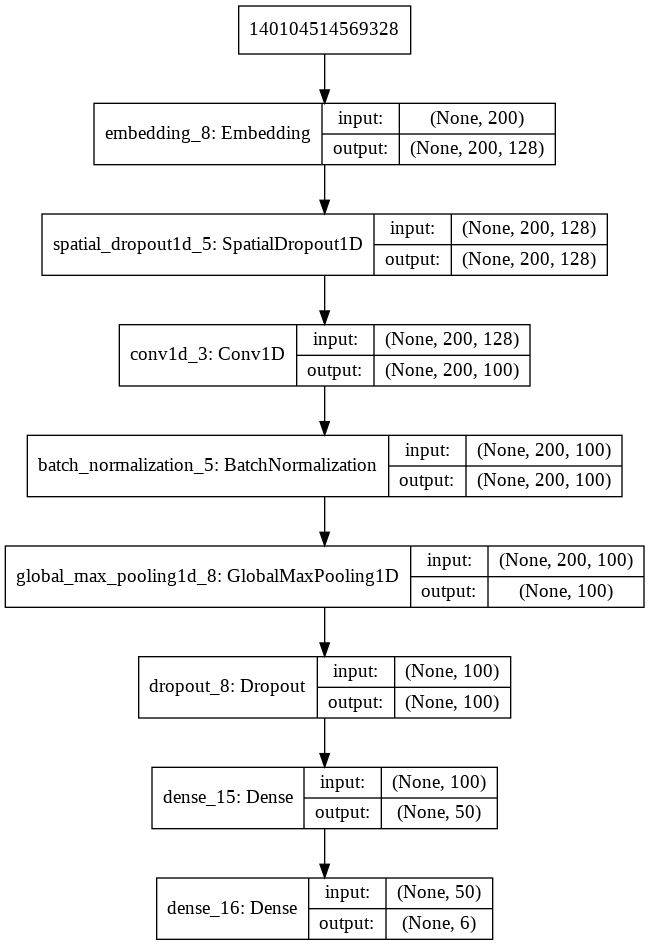

In [142]:
#plot the CNN_Word2Vec_model architecture

plot_model(CNN_Word2Vec_model, to_file='CNN_Word2Vec_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_Word2Vec_model_plot.png')

In [143]:
CNN_Word2Vec_model_fit = CNN_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 9s 64us/step - loss: 0.1544 - acc: 0.9627 - mean_pred: 0.0382 - val_loss: 0.1123 - val_acc: 0.9646 - val_mean_pred: 0.0296
Epoch 2/25
143613/143613 [==============================] - 7s 52us/step - loss: 0.1089 - acc: 0.9678 - mean_pred: 0.0372 - val_loss: 0.0954 - val_acc: 0.9697 - val_mean_pred: 0.0400
Epoch 3/25
143613/143613 [==============================] - 7s 52us/step - loss: 0.1028 - acc: 0.9691 - mean_pred: 0.0371 - val_loss: 0.0901 - val_acc: 0.9710 - val_mean_pred: 0.0360
Epoch 4/25
143613/143613 [==============================] - 7s 52us/step - loss: 0.0995 - acc: 0.9700 - mean_pred: 0.0368 - val_loss: 0.0884 - val_acc: 0.9714 - val_mean_pred: 0.0359
Epoch 5/25
143613/143613 [==============================] - 7s 52us/step - loss: 0.0969 - acc: 0.9704 - mean_pred: 0.0369 - val_loss: 0.0855 - val_acc: 0.9720 - val_mean_pred: 0.0360
Epoch 6/25
143613/143613 [========

#### Evaluate the CNN+Word2Vec Model accuracy of our trained model

In [144]:
CNN_Word2Vec_train_score = CNN_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_Word2Vec_train_score[0])
print('Train Accuracy:', CNN_Word2Vec_train_score[1])

159571/159571 [==============================] - 3s 21us/step
Train Loss: 0.07727353618559063
Train Accuracy: 0.974425168533493


#### Evaluate the CNN+Word2Vec accuracy base our test samples

In [145]:
CNN_Word2Vec_test_score = CNN_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_Word2Vec_test_score[0])
print('Test Accuracy:', CNN_Word2Vec_test_score[1])

63930/63930 [==============================] - 1s 21us/step
Test Loss: 0.09593485887448645
Test Accuracy: 0.9700036471986107


In [146]:
#Predicting......
print('Predicting....')
y_pred = CNN_Word2Vec_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 2s 26us/step


#### Plot Training & Validation Accuracy with the Loss values of the CNN-Word2Vec Model

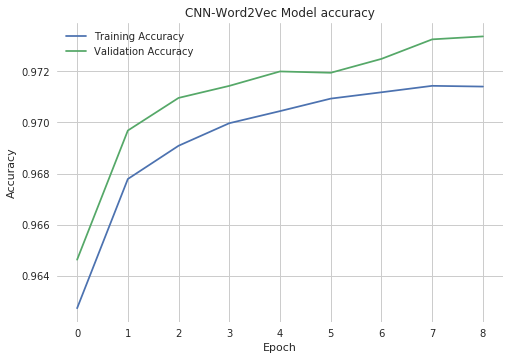

In [147]:
# Plot training & validation accuracy values
plt.plot(CNN_Word2Vec_model_fit.history['acc'])
plt.plot(CNN_Word2Vec_model_fit.history['val_acc'])
plt.title('CNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()


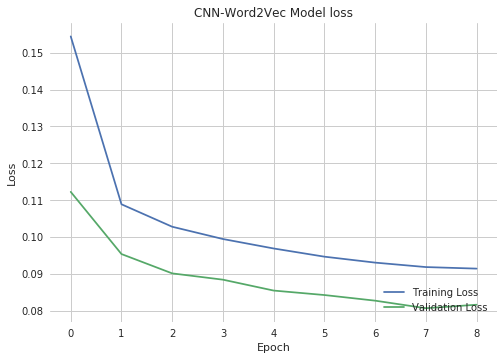

In [148]:
# Plot training & validation loss values
plt.plot(CNN_Word2Vec_model_fit.history['loss'])
plt.plot(CNN_Word2Vec_model_fit.history['val_loss'])
plt.title('CNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 7) Recurrent Neural Network (RNN) with Word2Vec

In [0]:
RNN_Word2Vec_model = Sequential([
    Embedding(input_dim =embedding_matrix.shape[0], input_length=max_len, output_dim=embedding_matrix.shape[1],weights=[embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

RNN_Word2Vec_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

####Visualize the Orchestrated RNN-Word2Vec Model Architecture

In [151]:
RNN_Word2Vec_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 200, 100)          21033800  
_________________________________________________________________
spatial_dropout1d_6 (Spatial (None, 200, 100)          0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200, 50)           25200     
_________________________________________________________________
batch_normalization_6 (Batch (None, 200, 50)           200       
_________________________________________________________________
dropout_9 (Dropout)          (None, 200, 50)           0         
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 50)                0         
_________________________________________________________________
dense_17 (Dense)             (None, 50)                2550      
__________

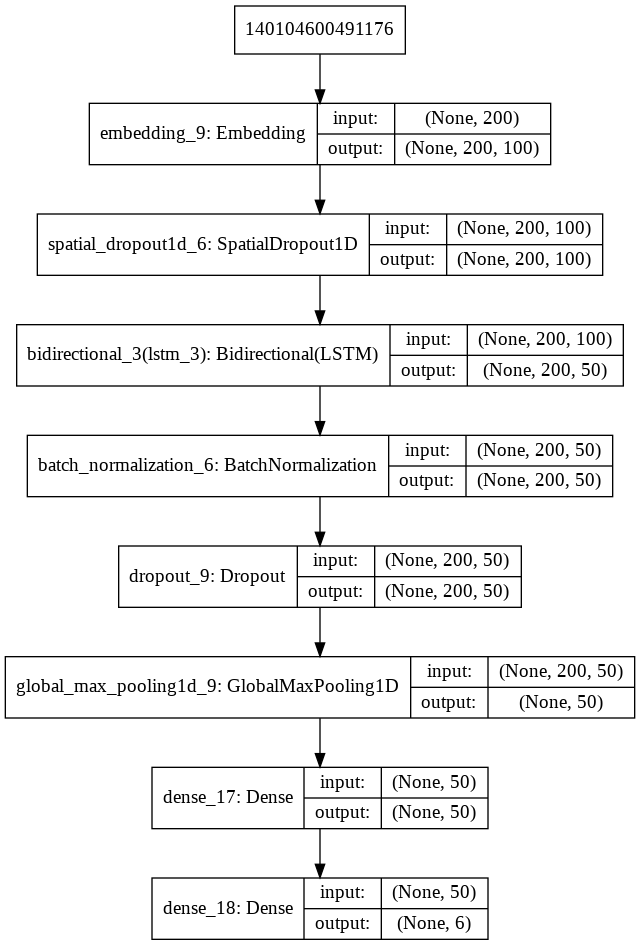

In [152]:
#plot the RNN_Word2Vec_model architecture

plot_model(RNN_Word2Vec_model, to_file='RNN_Word2Vec_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_Word2Vec_model_plot.png')

In [153]:
RNN_Word2Vec_model_fit = RNN_Word2Vec_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

Train on 143613 samples, validate on 15958 samples
Epoch 1/25
143613/143613 [==============================] - 332s 2ms/step - loss: 0.0841 - acc: 0.9723 - mean_pred: 0.0385 - val_loss: 0.0815 - val_acc: 0.9788 - val_mean_pred: 0.0647
Epoch 2/25
143613/143613 [==============================] - 330s 2ms/step - loss: 0.0654 - acc: 0.9772 - mean_pred: 0.0367 - val_loss: 0.0867 - val_acc: 0.9797 - val_mean_pred: 0.0729


#### Evaluate the RNN+Word2Vec Model accuracy of our trained model

In [154]:
RNN_Word2Vec_train_score = RNN_Word2Vec_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_Word2Vec_train_score[0])
print('Train Accuracy:', RNN_Word2Vec_train_score[1])

159571/159571 [==============================] - 149s 933us/step
Train Loss: 0.08443669945206297
Train Accuracy: 0.9804266760848923


#### Evaluate the RNN+Word2Vec accuracy base our test samples

In [155]:
RNN_Word2Vec_test_score = RNN_Word2Vec_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_Word2Vec_test_score[0])
print('Test Accuracy:', RNN_Word2Vec_test_score[1])

63930/63930 [==============================] - 61s 960us/step
Test Loss: 0.11086426996511602
Test Accuracy: 0.9709995174117069


In [156]:
#Predicting......
print('Predicting....')
y_pred = RNN_Word2Vec_model.predict(X_test,batch_size=batch_size2,verbose=1)

Predicting....
63930/63930 [==============================] - 59s 926us/step


#### Plot Training & Validation Accuracy with the Loss values of the RNN-Word2Vec Model

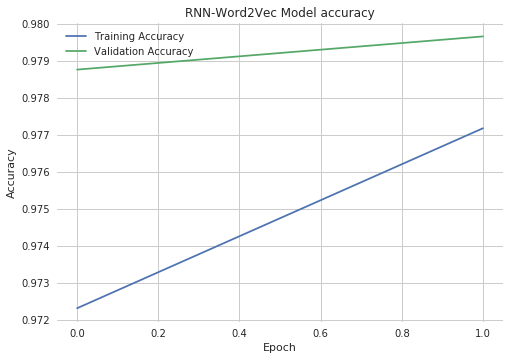

In [157]:
# Plot training & validation accuracy values
plt.plot(RNN_Word2Vec_model_fit.history['acc'])
plt.plot(RNN_Word2Vec_model_fit.history['val_acc'])
plt.title('RNN-Word2Vec Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

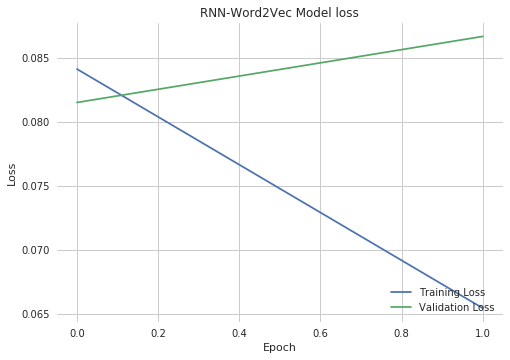

In [158]:
# Plot training & validation loss values
plt.plot(RNN_Word2Vec_model_fit.history['loss'])
plt.plot(RNN_Word2Vec_model_fit.history['val_loss'])
plt.title('RNN-Word2Vec Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

## C) "FasText" as a pre-trained Embedding

#### Load the FastText Word Embeddng Corpus

In [1]:
#load embeddings
print('loading word embeddings...')
fastText_embeddings_index = {}
f = codecs.open('wiki.simple.vec', encoding='utf-8')
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    fastText_embeddings_index[word] = coefs
f.close()
print('found %s word vectors' % len(fastText_embeddings_index))

loading word embeddings...


NameError: ignored

In [160]:
#embedding matrix
print('preparing embedding matrix...')
words_not_found = []
nb_words = min(MAX_NB_WORDS, len(word_index))
fastText_embedding_matrix = np.zeros((nb_words, embed_dim))
for word, i in word_index.items():
    if i >= nb_words:
        continue
    fastText_embedding_vector = fastText_embeddings_index.get(word)
    if (fastText_embedding_vector is not None) and len(fastText_embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        fastText_embedding_matrix[i] = fastText_embedding_vector
    else:
        words_not_found.append(word)
print('number of null word embeddings: %d' % np.sum(np.sum(fastText_embedding_matrix, axis=1) == 0))

preparing embedding matrix...


NameError: ignored

In [0]:
print(nb_words)

### 8) Convolutional Neural Network (CNN) with FastText

In [0]:
CNN_FastText_model = Sequential([
    Embedding(input_dim=fastText_embedding_matrix.shape[0], input_length=max_len, output_dim=fastText_embedding_matrix.shape[1],weights=[fastText_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    # ... 100 filters with a kernel size of 4 so that each convolution will consider a window of 4 word embeddings
    Conv1D(filters=100, kernel_size=4, padding='same', activation='relu'),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    #It will be added after the activation function between a convolutional and a max-pooling layer.
    BatchNormalization(),
    GlobalMaxPool1D(),
    Dropout(0.5),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [0]:
CNN_FastText_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

#### Visualize the Orchestrated CNN-FastText Model Architecture

In [0]:
CNN_FastText_model.summary()

In [0]:
#plot the CNN_FastText_model architecture

plot_model(CNN_FastText_model, to_file='CNN_FastText_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='CNN_FastText_model_plot.png')

In [0]:
CNN_FastText_model_fit = CNN_FastText_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

#### Evaluate the CNN+fastText Model accuracy of our trained model

In [0]:
CNN_FastText_train_score = CNN_FastText_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', CNN_FastText_train_score[0])
print('Train Accuracy:', CNN_FastText_train_score[1])

#### Evaluate the CNN+FastText accuracy base our test samples

In [0]:
CNN_FastText_test_score = CNN_FastText_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', CNN_FastText_train_score[0])
print('Test Accuracy:', CNN_FastText_train_score[1])

In [0]:
#Predicting......
print('Predicting....')
y_pred = CNN_FastText_model.predict(X_test,batch_size=batch_size2,verbose=1)

#### Plot Training & Validation Accuracy with the Loss values of the CNN-FastText Model

In [0]:
# Plot training & validation accuracy values
plt.plot(CNN_FastText_model_fit.history['acc'])
plt.plot(CNN_FastText_model_fit.history['val_acc'])
plt.title('CNN-FastText Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [0]:
# Plot training & validation loss values
plt.plot(CNN_FastText_model_fit.history['loss'])
plt.plot(CNN_FastText_model_fit.history['val_loss'])
plt.title('CNN-FastText Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### 9) Recurrent Neural Network (RNN) with FastText

In [0]:
RNN_FastText_model = Sequential([
    Embedding(input_dim =fastText_embedding_matrix.shape[0], input_length=max_len, output_dim=fastText_embedding_matrix.shape[1],weights=[fastText_embedding_matrix], trainable=False),
    SpatialDropout1D(0.5),
    #Bidirectional layer will enable our model to predict a missing word in a sequence, 
    #So, using this feature will enable the model to look at the context on both the left and the right.
    Bidirectional(LSTM(25, return_sequences=True)),
    #**batch normalization layer** normalizes the activations of the previous layer at each batch, 
    #i.e. applies a transformation that maintains the mean activation close to 0 and the activation standard deviation close to 1. 
    BatchNormalization(),
    Dropout(0.5),
    GlobalMaxPool1D(),
    Dense(50, activation = 'relu'),
    Dense(6, activation = 'sigmoid')
])

In [0]:
#Customized the evaluation to analyse the model in terms of accuracy and mean value accuracy
def mean_pred(y_true, y_pred):
    return K.mean(y_pred)

In [0]:
RNN_FastText_model.compile(loss='binary_crossentropy', optimizer=Adam(0.01), metrics=['accuracy', mean_pred])

#### Visualize the Orchestrated RNN-fastText Model Architecture

In [0]:
RNN_FastText_model.summary()

In [0]:
#plot the RNN_FastText_model architecture

plot_model(RNN_FastText_model, to_file='RNN_FastText_model_plot.png', show_shapes=True, show_layer_names=True)
Image(retina=True, filename='RNN_FastText_model_plot.png')

In [0]:
RNN_FastText_model_fit = RNN_FastText_model.fit(X_train, y_train, batch_size=batch_size2, epochs=num_epochs, validation_split=val_split, callbacks=[early])

#### Evaluate the RNN+fastText Model accuracy of our trained model

In [0]:
RNN_FastText_train_score = RNN_FastText_model.evaluate(X_train, y_train, batch_size=batch_size2, verbose=1)
print('Train Loss:', RNN_FastText_train_score[0])
print('Train Accuracy:', RNN_FastText_train_score[1])

#### Evaluate the RNN+FastText accuracy base our test samples

In [0]:
RNN_FastText_test_score = RNN_FastText_model.evaluate(X_test, y_test, batch_size=batch_size2, verbose=1)
print('Test Loss:', RNN_FastText_test_score[0])
print('Test Accuracy:', RNN_FastText_test_score[1])

In [0]:
#Predicting......
print('Predicting....')
y_pred = RNN_FastText_model.predict(X_test,batch_size=batch_size2,verbose=1)

#### Plot Training & Validation Accuracy with the Loss values of the RNN-fastText Model

In [0]:
# Plot training & validation accuracy values
plt.plot(RNN_FastText_model_fit.history['acc'])
plt.plot(RNN_FastText_model_fit.history['val_acc'])
plt.title('CNN-FastText Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left')
plt.show()

In [0]:
# Plot training & validation loss values
plt.plot(RNN_FastText_model_fit.history['loss'])
plt.plot(RNN_FastText_model_fit.history['val_loss'])
plt.title('CNN-FastText Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training Loss', 'Validation Loss'], loc='lower right')
plt.show()

### EVALUATION

In [0]:
# concat all training, validation and testing accuracy scores
NN_Accuracy = ['Neural Network', 
               np.mean(nn_model_fit.history['acc']), 
               np.mean(nn_model_fit.history['val_acc']), 
               nn_test_score[1]]

CNN_Accuracy = ['Convolutional Neural Network (CNN)', 
                np.mean(CNN_model_fit.history['acc']), 
                np.mean(CNN_model_fit.history['val_acc']), 
                CNN_test_score[1]]

RNN_Accuracy = ['Recurrent Neural Networks (RNNs)', 
                np.mean(RNN_model_fit.history['acc']), 
                np.mean(RNN_model_fit.history['val_acc']), 
                RNN_test_score[1]]

CNN_Glove_Accuracy = ['Convolutional Neural Network (CNN) with Glove', 
                  np.mean(CNN_Glove_model_fit.history['acc']), 
                  np.mean(CNN_Glove_model_fit.history['val_acc']), 
                  CNN_Glove_test_score[1]]

RNN_Glove_Accuracy = ['Recurrent Neural Networks (RNNs) with Glove', 
                    np.mean(RNN_Glove_model_fit.history['acc']), 
                    np.mean(RNN_Glove_model_fit.history['val_acc']), 
                    RNN_Glove_test_score[1]]

CNN_Word2Vec_Accuracy = ['Convolutional Neural Networks (CNNs) with Word2Vec', 
                    np.mean(CNN_Word2Vec_model_fit.history['acc']), 
                    np.mean(CNN_Word2Vec_model_fit.history['val_acc']), 
                    CNN_Word2Vec_test_score[1]]

RNN_Word2Vec_Accuracy = ['Recurrent Neural Networks (RNNs) with Word2Vec', 
                    np.mean(RNN_Word2Vec_model_fit.history['acc']), 
                    np.mean(RNN_Word2Vec_model_fit.history['val_acc']), 
                    RNN_Word2Vec_test_score[1]]

CNN_FastText_Accuracy = ['Convolutional Neural Networks (RNNs) with FastText', 
                    np.mean(RNN_FastText_model_fit.history['acc']), 
                    np.mean(RNN_FastText_model_fit.history['val_acc']), 
                    RNN_Word2Vec_test_score[1]]


RNN_FastText_Accuracy = ['Recurrent Neural Networks (RNNs) with FastText', 
                    np.mean(RNN_Word2Vec_model_fit.history['acc']), 
                    np.mean(RNN_Word2Vec_model_fit.history['val_acc']), 
                    RNN_Word2Vec_test_score[1]]


# create dataframe
comparison = pd.DataFrame([NN_Accuracy])
# append all other scores
comparison = comparison.append([CNN_Accuracy, RNN_Accuracy, CNN_Glove_Accuracy, RNN_Glove_Accuracy, CNN_Word2Vec_Accuracy, 
                                RNN_Word2Vec_Accuracy, CNN_FastText_Accuracy, RNN_FastText_Accuracy])


# beautify the new dataframe
comparison.columns = ['Model', 'Training Accuracy', 'Validation Accuracy', 'Testing Accuracy']
comparison.set_index(['Model'], inplace=True)
comparison
print(comparison)